In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

import common_functions as cf

## Import Data

In [23]:
df_all = pd.read_pickle("merged_df.pkl")

# Feature engineering (basic)

In [24]:
df_fe = cf.fe_basic_features(df_all)

# Feature engineering (Rolling)
rolling function takes an amount of directly preceding values to generate stuff like mean, median etc. So for my later input data, I don't need anything else than a set of preceding motion data.

In [22]:
ROLL_STEPS = 150

In [25]:
roll_df =  cf.fe_roll_features(df_fe,ROLL_STEPS)

In [26]:
roll_df

,accel_x,accel_x_rmean,accel_x_rstd,accel_x_rmed,accel_y,accel_y_rmean,accel_y_rstd,accel_y_rmed,accel_z,accel_z_rmean,...,rotR_y_rmean,rotR_y_rstd,rotR_y_rmed,rotR_z,rotR_z_rmean,rotR_z_rstd,rotR_z_rmed,action,label,action_num
time,,,,,,,,,,,,,,,,,,,,,
70,-0.014404,-0.040043,0.110797,-0.064697,-0.885254,-0.895386,0.181835,-0.933105,0.436279,0.365105,...,-11.637631,28.409311,-3.323171,-1.097561,7.008711,19.265084,1.310976,t_stand_left_DrinkBottle_10ml_1s_right,1,0
71,-0.017822,-0.045351,0.100035,-0.064697,-0.934082,-0.905790,0.161507,-0.935547,0.388184,0.356728,...,-11.979094,28.200616,-4.054878,-3.963415,6.899826,19.305790,1.067073,t_stand_left_DrinkBottle_10ml_1s_right,1,0
72,-0.004150,-0.050342,0.088293,-0.064697,-0.911865,-0.916183,0.135764,-0.935547,0.413818,0.348807,...,-12.322300,27.933394,-4.054878,-3.353659,6.811847,19.338726,0.884146,t_stand_left_DrinkBottle_10ml_1s_right,1,0
73,0.000000,-0.055022,0.075760,-0.064697,-0.909912,-0.925572,0.109375,-0.935547,0.410889,0.341330,...,-12.640244,27.680753,-4.054878,-2.500000,6.646341,19.368539,0.640244,t_stand_left_DrinkBottle_10ml_1s_right,1,0
74,-0.027100,-0.059588,0.063084,-0.064697,-0.949707,-0.934546,0.081251,-0.937378,0.368652,0.334124,...,-12.926829,27.444607,-4.054878,-6.707317,6.344077,19.410027,0.304878,t_stand_left_DrinkBottle_10ml_1s_right,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.904053,0.710536,0.166578,0.657471,-0.313721,-0.623755,0.185000,-0.676758,0.206299,0.220431,...,-17.506969,22.618400,-13.323171,-4.146341,-13.281359,23.223831,-6.006098,t_stand_hold_DrinkCup_10ml_1s_right,1,86
240,0.898438,0.716044,0.166323,0.663330,-0.350098,-0.616898,0.186133,-0.667603,0.214111,0.219259,...,-17.488676,22.632627,-13.323171,-6.646341,-13.216899,23.236067,-6.006098,t_stand_hold_DrinkCup_10ml_1s_right,1,86
241,0.914062,0.721725,0.166195,0.667358,-0.364014,-0.610596,0.187132,-0.654175,0.204346,0.218094,...,-17.521777,22.606910,-13.323171,-7.865854,-13.247387,23.227502,-6.189024,t_stand_hold_DrinkCup_10ml_1s_right,1,86


In [27]:
len(roll_df.columns)

31

## Data Splitting

In [28]:
train_df_roll,test_df_roll = cf.data_split_TrainTest(roll_df)

In [29]:
X_train_roll,y_train_roll = cf.data_split_FeatLabel(train_df_roll)
X_test_roll,y_test_roll = cf.data_split_FeatLabel(test_df_roll)

## Modeling

### Neurel Network

In [30]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


import tensorflow as tf
import sklearn
tf.random.set_seed(20) # to fix the randomization
import numpy as np
np.random.seed(20)# to fix the randomizationin sklearn
sklearn.random.seed(1)

In [31]:
input_dim = X_train_roll.shape[1]
cnn = Sequential()
cnn.add(Dense(80, input_dim=input_dim, activation='relu'))
cnn.add(Dropout(rate =0.2)) # drop some of the neurals in the back prop. analysis to avoid overfitting
cnn.add(BatchNormalization())
cnn.add(Dense(40, activation='relu'))
cnn.add(Dropout(rate =0.5))
cnn.add(BatchNormalization())
cnn.add(Dense(20, activation='relu'))
cnn.add(Dropout(rate =0.2))
cnn.add(BatchNormalization())
cnn.add(Dense(1, activation='sigmoid'))

In [32]:
print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 80)                2320      
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 80)               320       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 40)                3240      
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 40)               160       
 hNormalization)                                      

In [33]:
opt = keras.optimizers.Adam(learning_rate=0.02)

cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

X_train, val_X, y_train, val_y = train_test_split(X_train_roll, y_train_roll, shuffle=True,test_size=0.2 )

In [34]:
X_train_arr = np.asarray(X_train_roll)
y_train_arr = np.asarray(y_train_roll)
X_test_arr = np.asarray(X_test_roll)
y_test_arr = np.asarray(y_test_roll)
val_X =  np.asarray(val_X)
val_y =  np.asarray(val_y)

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [36]:
history = cnn.fit(X_train_arr, y_train_arr, epochs=100, batch_size=250,callbacks=[es,mc]
                  , validation_data=(val_X,val_y)
                  )


Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.6965
Epoch 1: val_accuracy improved from -inf to 0.78074, saving model to best_model.h5
128/128 [==============================] - 6s 14ms/step - loss: 0.5689 - accuracy: 0.6965 - val_loss: 0.4439 - val_accuracy: 0.7807
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.7803
Epoch 2: val_accuracy improved from 0.78074 to 0.82005, saving model to best_model.h5
128/128 [==============================] - 1s 11ms/step - loss: 0.4594 - accuracy: 0.7803 - val_loss: 0.3632 - val_accuracy: 0.8200
Epoch 3/100
122/128 [===========================>..] - ETA: 0s - loss: 0.4105 - accuracy: 0.8101
Epoch 3: val_accuracy improved from 0.82005 to 0.84589, saving model to best_model.h5
128/128 [==============================] - 1s 12ms/step - loss: 0.4103 - accuracy: 0.8104 - val_loss: 0.3418 - val_accuracy: 0.8459
Epoch 4/100
123/128 [===========================>..] - ETA

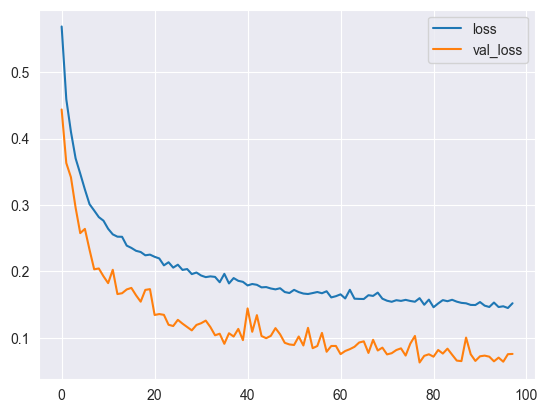

In [37]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss',"val_loss"]].plot()
plt.show()

#### Evaluation

- Evaluate best model which was monitored and saved

In [38]:
best_saved_model = load_model('best_model.h5')
_, train_acc = best_saved_model.evaluate(X_train_arr, y_train_arr, verbose=0)
_, test_acc = best_saved_model.evaluate(X_test_arr, y_test_arr, verbose=0)
print('Train: %.2f, Test: %.2f' % (train_acc*100, test_acc*100))

Train: 97.91, Test: 82.91


In [39]:

best_model_predictions = best_saved_model.predict(X_test_arr)
mae = round(mean_absolute_error(y_test_roll, best_model_predictions),3)
print("mean absolute error is",mae)

819/819 [==============================] - 3s 3ms/step
mean absolute error is 0.183


In [40]:
# convert predicted label rom analog to binary value
bin_best_model_predictions=[]
for val in best_model_predictions:
    if val >=0.5:
        bin_best_model_predictions.append(1)
    else:
        bin_best_model_predictions.append(0)

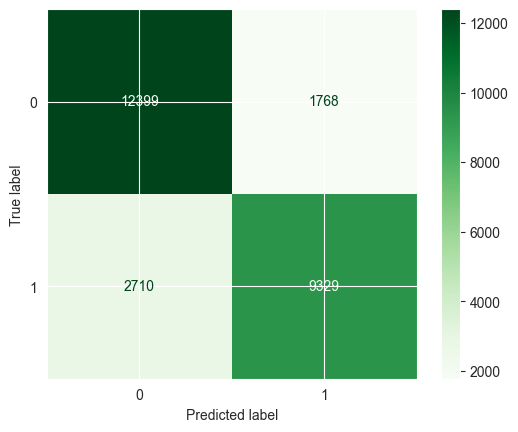

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(bin_best_model_predictions, y_test_roll)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
conf_mat_disp.plot(cmap='Greens')
plt.show()